In [2]:
import pandas as pd
import numpy  as np

import data file

In [3]:
df = pd.read_csv('data_20s.csv')
df.describe()

,Label
count,3239.000000
mean,0.502007
std,0.500073
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


parse data from string to numpy array

In [4]:
def parseData(series):
    final_series = []
    for ser in series:
        temp = []
        for x in "[],":
            ser = ser.replace(x, "")
        new_ser  = np.fromstring(ser, dtype=float, sep=" ")
        for i in range(0, len(new_ser), 3):
            chunk = [new_ser[i], new_ser[i + 1], new_ser[i + 2]]
            temp.append(chunk)
        final_series.append(temp)
    return np.array(final_series, dtype=object)

get the longest sequence of vector in dataset

In [5]:
max_length = 0
for lgaze in parseData(df['Left Gaze']):
    if len(lgaze) > max_length:
        max_length = len(lgaze)
        
print(max_length)

min_length = max_length
indices = []
for idx, lgaze in enumerate(parseData(df['Left Gaze'])):
    if len(lgaze) <= min_length:
        min_length = len(lgaze)
        print(min_length, idx)
    if len(lgaze) == 0:
        indices.append(idx)

print(min_length, indices)

599
598 0
597 1
537 2
451 7
298 36
98 58
97 188
97 302
80 750
44 1976
0 1977
0 1978
0 1979
0 1980
0 [1977, 1978, 1979, 1980]


In [6]:
# remove unsuable data
df = df.drop(indices)
df = df.drop([58, 188, 302, 80, 44])

split data

In [7]:
print("Non-cheat: ", len(df[df['Label']==0]))
print("Cheat: ", len(df[df['Label']==1]))

grouped = df.groupby(df.Label)
df1 = grouped.get_group(1)
df2 = grouped.get_group(0)

df2_1 = df2.iloc[:1609,:]
df2_2 = df2.iloc[1609:1626,:]

df1_train = df1.iloc[:1126,:]
df2_train = df2_1.iloc[:1126,:]

df1_test = df1.iloc[1126:1609,:]
df2_test = df2_1.iloc[1126:1609,:]

train = pd.concat([df1_train, df2_train])
test  = pd.concat([df1_test, df2_test, df2_2])

# shuffle the train set
train = train.sample(frac=1)

print((len(train), len(test)))

Non-cheat:  1609
Cheat:  1621
(2252, 966)


In [8]:
print("Non-cheat in train: ", len(train[train['Label']==0]))
print("Cheat in train: ", len(train[train['Label']==1]))

Non-cheat in train:  1126
Cheat in train:  1126


pad the dataset to the longest sequence size

In [9]:
import math

def padData(series, length):
    for idx, ser in enumerate(series):
        times = math.floor(length / len(ser))
        add = length % len(ser)
        
        temp = ser[::-1]
        for _ in range(1, times):
            series[idx] = np.append(series[idx], temp, axis=0)
            temp = temp[::-1]
        if add != 0:
            series[idx] = np.append(series[idx], temp[0:add], axis=0)
    return series

Conv1D -> AveragePooling1D -> Conv1D -> LSTM -> Dense

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, AveragePooling1D, LSTM, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, History

import tensorflow as tf

def init_model():
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    
    model.add(LSTM(12))
    
    model.add(Dropout(0.1))
    
    model.add(Flatten())
    model.add(Dense(2, activation = 'softmax')) # We have only 2 classes: Non-cheat & Cheat
    
    adam = optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    
    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    
    return model

In [11]:
right_gaze_train = train["Right Gaze"]
left_gaze_train  = train["Left Gaze"]
right_head_train = train["Right HeadPose"]
left_head_train  = train["Left HeadPose"]
label_train = train['Label']

right_gaze_train, left_gaze_train, right_head_train, left_head_train = parseData(right_gaze_train), parseData(left_gaze_train), parseData(right_head_train), parseData(left_head_train)

initialize new data frame

In [12]:
left_head_train  = padData(left_head_train,  max_length)
right_head_train = padData(right_head_train, max_length)
left_gaze_train  = padData(left_gaze_train,  max_length)
right_gaze_train = padData(right_gaze_train, max_length)

In [13]:
label_train = np.array(label_train)

In [14]:
y_train = []
for i in range(len(label_train)):
    y_train.append(
        tf.convert_to_tensor(
            np.reshape(tf.keras.utils.to_categorical(label_train[i], num_classes=2), (1, 2))                 
                            )
             )
    
y_train = tf.convert_to_tensor(np.vstack(y_train), dtype=tf.float32)

In [15]:
x_train = []

for i in range(len(left_gaze_train)):
    x_train.append(tf.convert_to_tensor([
                                            np.hstack(
                                                        (left_gaze_train[i], right_gaze_train[i], left_head_train[i], right_head_train[i])
                                                     )
                                            ], dtype=tf.float32))



x_train = tf.convert_to_tensor(np.vstack(x_train), dtype=tf.float32)

print(x_train)

print(y_train)

tf.Tensor(
[[[ 42.221   8.741  43.116 ...  38.869  -9.403  39.99 ]
  [ 43.478   9.456  44.495 ...  39.628  -8.942  40.624]
  [ 44.947   8.68   45.777 ...  41.212  -8.862  42.154]
  ...
  [  8.089  23.966  25.294 ...  18.8     5.389  19.557]
  [  8.547  23.801  25.289 ...  19.556   4.436  20.053]
  [  8.547  23.801  25.289 ...  19.556   4.436  20.053]]

 [[-53.613  16.166  55.997 ... -73.839   9.421  74.438]
  [-48.408   8.25   49.106 ... -70.601   5.159  70.789]
  [-43.077   5.556  43.434 ... -68.277   3.502  68.366]
  ...
  [ 83.049 -12.128  83.93  ...  76.056  -8.198  76.496]
  [ 82.221 -10.262  82.859 ...  71.935  -4.558  72.08 ]
  [ 82.221 -10.262  82.859 ...  71.935  -4.558  72.08 ]]

 [[-37.334  43.03   56.969 ... -22.002  36.211  42.371]
  [-38.298  45.136  59.194 ... -22.62   34.616  41.351]
  [-33.016  45.43   56.16  ... -18.224  35.693  40.076]
  ...
  [ -9.354   6.918  11.634 ...  -1.063  -8.267   8.335]
  [-11.875   6.354  13.468 ...  -3.386  -7.835   8.536]
  [-11.875   6.

Train the model

In [16]:
right_gaze_test = test["Right Gaze"]
left_gaze_test  = test["Left Gaze"]
right_head_test = test["Right HeadPose"]
left_head_test  = test["Left HeadPose"]
label_test = test['Label']
label_test = np.array(label_test)

right_gaze_test, left_gaze_test, right_head_test, left_head_test = parseData(right_gaze_test), parseData(left_gaze_test), parseData(right_head_test), parseData(left_head_test)

In [17]:
left_head_test  = padData(left_head_test,  max_length)
right_head_test = padData(right_head_test, max_length)
left_gaze_test  = padData(left_gaze_test,  max_length)
right_gaze_test = padData(right_gaze_test, max_length)

In [18]:
x_test = []
y_test = []
for i in range(len(left_gaze_test)):
    x_test.append(tf.convert_to_tensor([
                                            np.hstack(
                                                        (left_gaze_test[i], right_gaze_test[i], left_head_test[i], right_head_test[i])
                                                     )
                                            ], dtype=tf.float32))                                        
for i in range(len(label_test)):
    y_test.append(
        tf.convert_to_tensor(np.reshape(tf.keras.utils.to_categorical(label_test[i], num_classes=2), (1, 2)))
             )
    
x_test = tf.convert_to_tensor(np.vstack(x_test), dtype=tf.float32)
y_test = tf.convert_to_tensor(np.vstack(label_test), dtype=tf.float32)
print(x_test.shape, y_test.shape)

(966, 599, 12) (966, 1)


In [21]:
model = init_model()
# callbacks = [EarlyStopping(monitor='val_loss', patience=3), History()]
callbacks = [History()]
history = model.fit(x_train, y_train,validation_split=0.1, epochs=200, batch_size=64, callbacks=callbacks)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 599, 12)           444       
                                                                 
 average_pooling1d_1 (Averag  (None, 299, 12)          0         
 ePooling1D)                                                     
                                                                 
 conv1d_3 (Conv1D)           (None, 299, 12)           444       
                                                                 
 lstm_1 (LSTM)               (None, 12)                1200      
                                                                 
 dropout_1 (Dropout)         (None, 12)                0         
                                                                 
 flatten_1 (Flatten)         (None, 12)                0         
                                                      

Predict test set

In [22]:
results = model.evaluate(x_test, y_test, batch_size=128)
print(results)
predictions = model.predict(x_test)

label_predictions = []

# convert from category to label
for prediction in predictions:
    if prediction[0] > prediction[1]:
        label_predictions.append(0)
    else: label_predictions.append(1)
    
label_predictions = np.array(label_predictions)
label_test = np.array(label_test)

print(label_predictions)
print(label_test)

# calc acc
true_count = 0
for idx, label in enumerate(label_predictions):
    if label == label_test[idx]:
        true_count += 1
        
print("Accuracy on test set: ", true_count/(len(label_test)))

8/8 [==============================] - 1s 41ms/step - loss: 0.9389 - accuracy: 0.5124
[0.9389437437057495, 0.5124223828315735]
31/31 [==============================] - 2s 28ms/step
[1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0
 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1
 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0
 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 0 1
 1 1 0 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [23]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [24]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

plot the loss and acc from training process

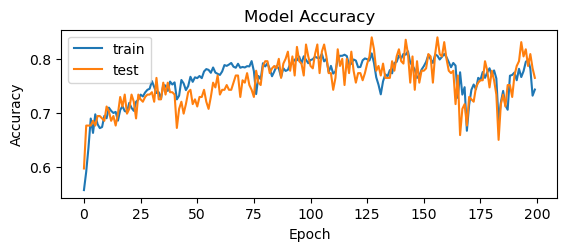

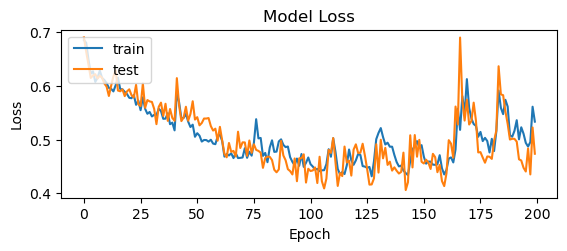

In [25]:
from matplotlib import pyplot as plt
# Plot accuracy
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot loss
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save("GP046.keras")